In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

merged_data = pd.merge(transactions, customers, on='CustomerID', how='inner')




In [5]:
current_date = datetime(2025, 1, 1)
customer_features = merged_data.groupby('CustomerID').agg({
    'TransactionID': 'count',  
    'TotalValue': 'sum',       
    'Quantity': 'sum',         
    'TransactionDate': lambda x: (current_date - x.max()).days  
}).rename(columns={
    'TransactionID': 'TotalTransactions',
    'TotalValue': 'TotalValue',
    'Quantity': 'TotalQuantity',
    'TransactionDate': 'Recency'
}).reset_index()

scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_features.iloc[:, 1:])



C:\Users\Magesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


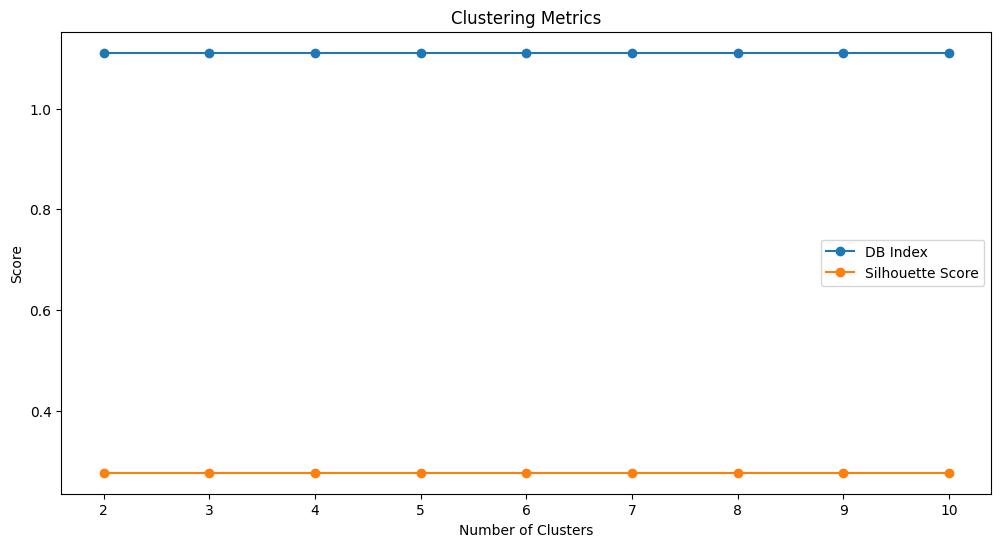

In [6]:
cluster_range = range(2, 11)  
db_scores = []
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    customer_features['Cluster'] = kmeans.fit_predict(normalized_features)
    db_index = davies_bouldin_score(normalized_features, clusters)
    silhouette_avg = silhouette_score(normalized_features, clusters)
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)

optimal_k = cluster_range[np.argmin(db_scores)]

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(normalized_features)

plt.figure(figsize=(12, 6))
plt.plot(cluster_range, db_scores, marker='o', label='DB Index')
plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Clustering Metrics')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()



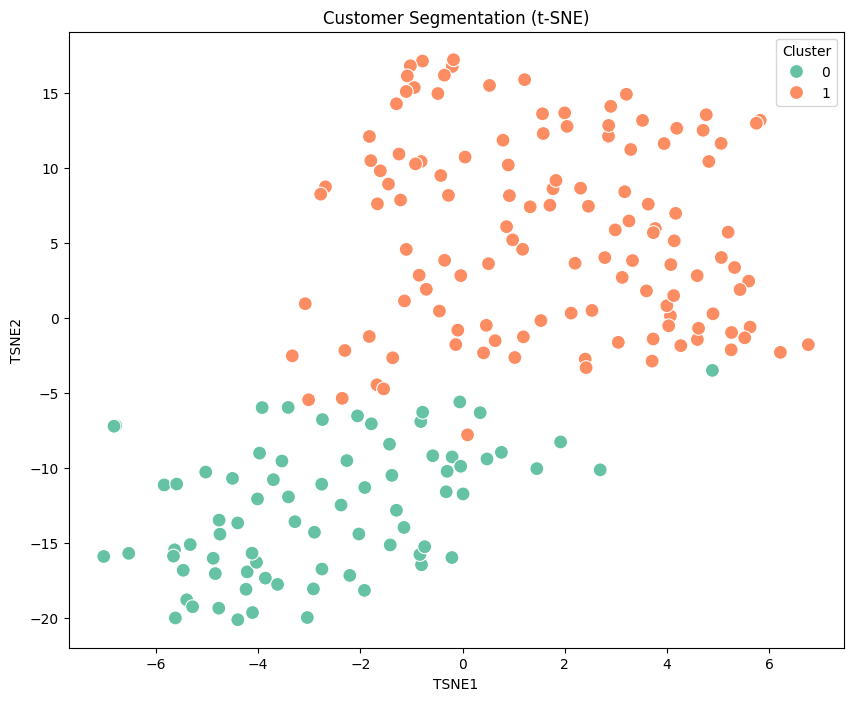

Optimal Number of Clusters: 2
DB Index for Optimal Clustering: 1.1107801273562068
Cluster Summary:
          TotalTransactions  TotalValue  TotalQuantity  Recency
Cluster                                                       
0                     7.14     5220.89          18.96    60.58
1                     3.72     2383.80           8.91    87.92


In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(normalized_features)

customer_features['TSNE1'] = tsne_results[:, 0]
customer_features['TSNE2'] = tsne_results[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='TSNE1', y='TSNE2', hue='Cluster', palette='Set2', data=customer_features, s=100
)
plt.title('Customer Segmentation (t-SNE)')
plt.legend(title='Cluster')
plt.show()

cluster_summary = customer_features.groupby('Cluster').agg({
    'TotalTransactions': 'mean',
    'TotalValue': 'mean',
    'TotalQuantity': 'mean',
    'Recency': 'mean'
}).round(2)

print("Optimal Number of Clusters:", optimal_k)
print("DB Index for Optimal Clustering:", np.min(db_scores))
print("Cluster Summary:\n", cluster_summary)